<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">


---
<h3>Jon Amelibia, Iker Cumplido, Aitor Hernandez, Daniel Puente and Iñigo Ugarte

## Index
---

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Preprocessing data to enter it to the GAN<ins></a>
- <a href='#3'><ins>3. GAN architecture<ins> </a>
- <a href='#4'><ins>4. Re-train models with the augmented data<ins></a>

### <a id='1'>1. Loading of Libraries and Data</a>
---

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from itertools import chain

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [2]:
path_origin, path_processed = "../data/original_data/", "../data/processed_data/"
models_path, models_path_normal = "../data/processed_data/gans_models/", "../data/processed_data/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

In [3]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
print(df_desc_final_pickle.shape)

(390, 41)


Plot functions

In [4]:
def scatter_cycle_plot(df_desc_final_pickle_load, battery, ypred, y_test, y_test_mod, index = False):

    differences = (y_test - ypred).flatten()
    list_soh = []
    for k, v in enumerate(differences):
        if y_test_mod[:,1][k] == battery:
            df_modify = df_desc_final_pickle_load.loc[y_test_mod[:,1][k],:]
            yellow = df_modify.head(1).RUL[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(0)[0]
            red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
            list_soh.append(v)

    plt.scatter(range(len(list_soh)), np.sort(list_soh), s = 110, color='k')
    plt.xticks(fontsize=22), plt.yticks(fontsize=22);
    plt.grid(linestyle='--',linewidth=1.5, alpha = 0.4);
    plt.xlabel('Instances', fontsize=24), plt.ylabel('Cycle error', fontsize=24), plt.title(f'Prediction cell {battery}', fontsize=24, fontweight='bold');

    yellow_lim = np.max(list_soh) + 50 if np.max(list_soh) > yellow else 100
    red_lim = np.min(list_soh) - 100 if np.min(list_soh) < 50 else 100
    annotation = abs((yellow + yellow_lim) - (red+red_lim)) / 40

    plt.axhspan(red, red+red_lim, facecolor='#f50400', alpha=0.3), plt.axhspan(yellow + yellow_lim, yellow, facecolor='#f4b41a', alpha=0.4), \
                                                                   plt.axhspan(yellow, 0, facecolor='#68da3e', alpha=0.4), plt.axhspan(0, red, facecolor='#f4b41a', alpha=0.4);
    for k,v in enumerate(np.sort(list_soh)): 
        if int(np.round(v)) < 0: plt.annotate( str(int(np.round(v))), (k, v + annotation), fontsize=18, color = 'r', fontweight='bold', rotation=90)
        else: plt.annotate( str(int(np.round(v))), (k, v + annotation), fontsize=14, color = 'k', fontweight='bold',rotation=90);
    plt.ylim(red+red_lim, yellow + yellow_lim);

def scatter_plot_prediction(ypred, y_test, y_test_mod):
    fig = plt.figure(figsize=(50, 20))
    for x in range(1, 9):
        plt.subplot(2, 4, x)
        scatter_cycle_plot(df_desc_final_pickle_load, x, ypred, y_test, y_test_mod, False)
def line_plot_result(ypred, y_test, title):
    ypred_ordered = ypred[np.argsort(y_test, axis=0)]
    y_test_ordered = np.sort(y_test, axis=0)

    plt.plot(y_test_ordered,  label='Real', color='#E76F51', linewidth=3);
    plt.plot(ypred_ordered.reshape(-1,1), 'bo',label='Prediction', color='#264653', linewidth=1);
    plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.5);
    plt.xlabel('Instances', fontsize=16), plt.ylabel('Cycles', fontsize=16), plt.title('Model results' + title, fontsize=16, fontweight='bold');
    plt.legend(fontsize=16);
     
def green_yellow_red(ypred, y_test, y_test_mod):
    differences = (y_test - ypred).flatten()
    red_list, yellow_list, green_list = [], [], []
    for k, v in enumerate(differences):
        df_modify = df_desc_final_pickle_load[df_desc_final_pickle_load.index.get_level_values(0) == y_test_mod[k][1]]
        yellow = df_modify.head(1).RUL.values[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(1)[0]
        red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
        if (v <= yellow) & (v >= 0): green_list.append(k)
        if (v <= red): red_list.append(k)
        if ((v > red) & (v < 0)) | (v > yellow) : yellow_list.append(k)
    sum_list = len(red_list) + len(yellow_list) + len(green_list)
    return 100*(len(green_list)/sum_list), 100*len(yellow_list)/sum_list, 100*len(red_list)/sum_list

def bar_plot_comparison(nombres, list_red, list_yellow, list_green):
    X_axis = np.arange(len(nombres))
    fig1, ax1 = plt.subplots(figsize=(20, 5))
    plt.bar(X_axis - 0.2, list_red, 0.2, color = '#f50400', label = 'Dangerous', alpha = 0.3)
    plt.bar(X_axis, list_yellow, 0.2, color = '#f4b41a', label = 'Aceptable', alpha = 0.3)
    plt.bar(X_axis + 0.2, list_green, 0.2, color = '#68da3e', label = 'Excelent', alpha = 0.3)
    plt.xticks(X_axis, nombres, fontsize = 15), plt.yticks(fontsize = 15);
    plt.xlabel("Models", color = 'k',fontsize=15), plt.ylabel("% of bateries", color = 'k',  fontsize=15)
    plt.title("Model results", color = 'k', weight = 'bold', fontsize=18)
    plt.ylim(0, 100)
    for p in ax1.patches: plt.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=14, weight = 'bold')

### <a id='2'>Preprocessing data to enter it to the GAN</a>
---

In [5]:
X_train, num_steps, quantiles_final = [], 10, []
for i in [1,2,3,4,5,7,8]:
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    quantiles = []
    for j in range(1, len(batery_df) - num_steps):

        X_train.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].values))
        
X_train = np.array(X_train)
X_train.shape
X_train = np.stack(X_train, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

### <a id='3'>GAN architecture</a>
---

In [9]:
class LSTMGAN():
    
    def __init__(self):
        # Input shape
        self.img_rows = 11
        self.img_cols = 41
        self.img_shape = (self.img_rows, self.img_cols)
        self.latent_dim = 11*41

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates song
        z = Input(shape=(X_train.shape[1], X_train.shape[2]))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(RepeatVector(11))
        model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Bidirectional(LSTM(80, return_sequences=True, dropout = 0.2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(LSTM(41, return_sequences=True, batch_input_shape=(80, 11, 41)))
        model.summary()
        noise = Input(shape=(X_train.shape[1], X_train.shape[2]))
        img = model(noise)
        mm = Model(noise, img)
        return mm

    def build_discriminator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Bidirectional(LSTM(128, activation = 'relu')))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(RepeatVector(1))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(80, activation = 'relu')))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation = 'sigmoid'))
        model.summary()
        img = Input(shape=(X_train.shape[1], X_train.shape[2]))
        validity = model(img)
        mm = Model(img, validity)
        return mm
    

    def train(self, epochs, batch_size=80, save_interval=50):
        # Adversarial ground truths
        valid = np.ones((batch_size,1,1))
        fake = np.zeros((batch_size,1,1))

        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, X_train.shape[1], X_train.shape[2]))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save(models_path + f"LSTM_generator_{epoch}.h5")

In [10]:
lstmgan = LSTMGAN()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 11, 256)          174080    
 nal)                                                            
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 11, 256)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 256)          

In [11]:
lstmgan.train(epochs=5000, batch_size=80, save_interval=100)

3/3 [==============================] - 3s 20ms/step
0 [D loss: 0.674844, acc.: 36.25%] [G loss: 0.692867]
3/3 [==============================] - 0s 20ms/step
1 [D loss: 0.667276, acc.: 36.25%] [G loss: 0.692943]
3/3 [==============================] - 0s 18ms/step
2 [D loss: 0.656139, acc.: 42.50%] [G loss: 0.693054]
3/3 [==============================] - 0s 19ms/step
3 [D loss: 0.654608, acc.: 45.62%] [G loss: 0.693138]
3/3 [==============================] - 0s 18ms/step
4 [D loss: 0.644509, acc.: 61.88%] [G loss: 0.693328]
3/3 [==============================] - 0s 17ms/step
5 [D loss: 0.637461, acc.: 59.38%] [G loss: 0.693464]
3/3 [==============================] - 0s 16ms/step
6 [D loss: 0.620989, acc.: 73.12%] [G loss: 0.693652]
3/3 [==============================] - 0s 18ms/step
7 [D loss: 0.627750, acc.: 70.62%] [G loss: 0.693769]
3/3 [==============================] - 0s 18ms/step
8 [D loss: 0.605383, acc.: 66.25%] [G loss: 0.693494]
3/3 [==============================] - 0s 18ms

KeyboardInterrupt: 

### <a id='4'>Re-train model with augmented data</a>
---

We generate the new data points

In [8]:
batch_size = 128
random = np.random.normal(0, 1, (batch_size, X_train.shape[1], 41))
from keras.models import load_model
gan_model = load_model(models_path + "LSTM_generator_1100.h5")
X_train_augmented = gan_model.predict(random)
X_train_augmented = scaler.inverse_transform(X_train_augmented.reshape(-1, X_train_augmented.shape[-1])).reshape(X_train_augmented.shape)

4/4 [==============================] - 3s 30ms/step


Functio to get x and y

In [8]:
def x_and_y(df_desc_final_pickle, num_steps = 10, index = False):
    x, y, quantiles_final, new_values = [], [], [], []

    for i in range(1, 9):
        if index:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.cell == i]
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):
                x.append(np.array(batery_df.iloc[slice(j,num_steps+j), 1:].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.iloc[slice(j,num_steps+j), 1:].RUL.values[-1], i]))
                quantiles.append(i)
        else:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
            batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):

                x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1], i]))
                quantiles.append(i)

        quantiles_final.append(np.array_split(range(len(quantiles)), 4))
            
    x, y = np.array(x), np.array(y)

    for j in np.unique(y[:,1]):
        batery_column = y[:,1][y[:,1] == j]
        new_values.append([i+1 for i in range(4) for x in batery_column[quantiles_final[int(j-1)][i]].tolist()])
    y = np.append(y, np.array(list(chain(*new_values))).reshape(-1,1), axis = 1)
    y[:,0] = y[:,0].astype(float)
    print(x.shape, y.shape)
    return x, y

x, y = x_and_y(df_desc_final_pickle, num_steps = 10, index = False)
X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,[1,2]])
y_train, y_test = y_train_mod[:,0].reshape(-1,1), y_test_mod[:,0].reshape(-1,1)
X_train, y_train, X_test, y_test = np.stack(X_train, axis = 0), np.stack(y_train, axis = 0), np.stack(X_test, axis = 0), np.stack(y_test, axis = 0)

(302, 11, 40) (302, 3)


Concatenate new values to the original dataset

In [9]:
new_X_train, new_y_train = np.concatenate((X_train, X_train_augmented[:,:,:-1]), axis = 0), np.concatenate((y_train, X_train_augmented[:,:,-1][:,-1].reshape(-1,1)), axis = 0)
scaler = StandardScaler()
new_X_train = scaler.fit_transform(new_X_train.reshape(-1, new_X_train.shape[-1])).reshape(new_X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

new_X_train.shape, new_y_train.shape

((369, 11, 40), (369, 1))

We load the best models and compile them again to train them with the augmented data.

In [10]:
def customLoss(true,pred):
    diff = pred - true
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) 
    greater = greater + 1                
    return K.mean(K.square(diff))*greater

def customLoss_numpy(true,pred):
    diff = pred - true
    greater = np.max(diff)
    greater = greater + 1     
    return np.mean(greater*(diff**2))

**Model**

In [8]:
early_stopping = keras.callbacks.EarlyStopping(patience=3000, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=150, factor=0.5, min_lr=0.00001)

lstm_model = keras.models.load_model(models_path_normal + f'first_model_Bidirectional_LSTM_good_adapted.h5', custom_objects={'customLoss': customLoss})
lstm_hyperas_model = keras.models.load_model(models_path_normal + f'tryals_bidirectional_lstm_24.h5', custom_objects={'customLoss': customLoss})

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(loss=customLoss, optimizer=optimizer, metrics=['mae'])

Training the lstm

In [9]:
np.random.seed(26), tf.random.set_seed(26)
checkpoint_first_model_Bi_LSTM = keras.callbacks.ModelCheckpoint(models_path_normal + 'first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5', verbose = 1, save_best_only=True, monitor='loss')
historyBiLSTM = lstm_model.fit(new_X_train, new_y_train, epochs=8000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_Bi_LSTM, early_stopping, reduce_lr])


Epoch 1: loss improved from inf to 216015.53125, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 2: loss did not improve from 216015.53125

Epoch 3: loss improved from 216015.53125 to 91552.28125, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 4: loss improved from 91552.28125 to 26454.10547, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 5: loss improved from 26454.10547 to 20415.07812, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 6: loss improved from 20415.07812 to 19405.96094, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 7: loss improved from 19405.96094 to 16745.92773, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 8: loss improv

In [24]:
### NEW MODEL
early_stopping = keras.callbacks.EarlyStopping(patience=3000, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=150, factor=0.5, min_lr=0.00001)
checkout = keras.callbacks.ModelCheckpoint(models_path_normal + 'first_model_Bidirectional_LSTM_good_adapted_GAN_Cell6.h5', verbose = 1, save_best_only=True, monitor='loss')

model_gan = load_model(models_path_normal + "first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5", custom_objects={'customLoss': customLoss})
model_gan.trainable = False
model_gan.compile(loss=customLoss, optimizer=optimizer, metrics=['mae'])
history = model_gan.fit(x, y[y[:,2] != 6][:,0], epochs=8000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkout, early_stopping, reduce_lr])

### <a id='5'>5. Results</a>
---

In [11]:
model_gan = load_model(models_path_normal + "first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5", custom_objects={'customLoss': customLoss})
ypred = model_gan.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), customLoss_numpy(ypred, y_test))
green_list_1_test, yellow_list_1_test, red_list_1_test = green_yellow_red(ypred, y_test, y_test_mod)
print(green_list_1_test, yellow_list_1_test, red_list_1_test)

ypred_train = model_gan.predict(new_X_train)
print('Train -->', r2_score(new_y_train, ypred_train), mean_absolute_error(new_y_train, ypred_train), np.sqrt(mean_squared_error(new_y_train, ypred_train)), customLoss_numpy(ypred_train, new_y_train))
green_list_1_train, yellow_list_1_train, red_list_1_train = green_yellow_red(ypred_train[:241], y_train, y_train_mod)
print(green_list_1_train, yellow_list_1_train, red_list_1_train)

2/2 [==============================] - 1s 45ms/step
Test --> 0.9947351122513486 64.22324934162077 99.40512008928006 4254574.896511096
80.32786885245902 16.39344262295082 3.278688524590164
12/12 [==============================] - 1s 47ms/step
Train --> 0.9979576025905863 38.79483898545345 49.22948327023189 413379.5867486963
100.0 0.0 0.0


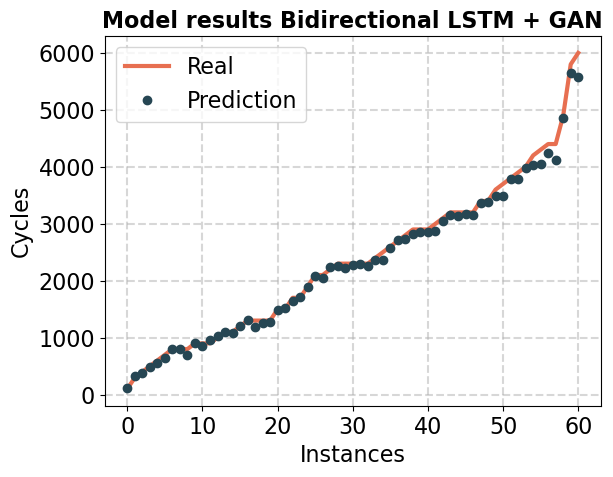

In [12]:
line_plot_result(ypred, y_test, ' Bidirectional LSTM + GAN')

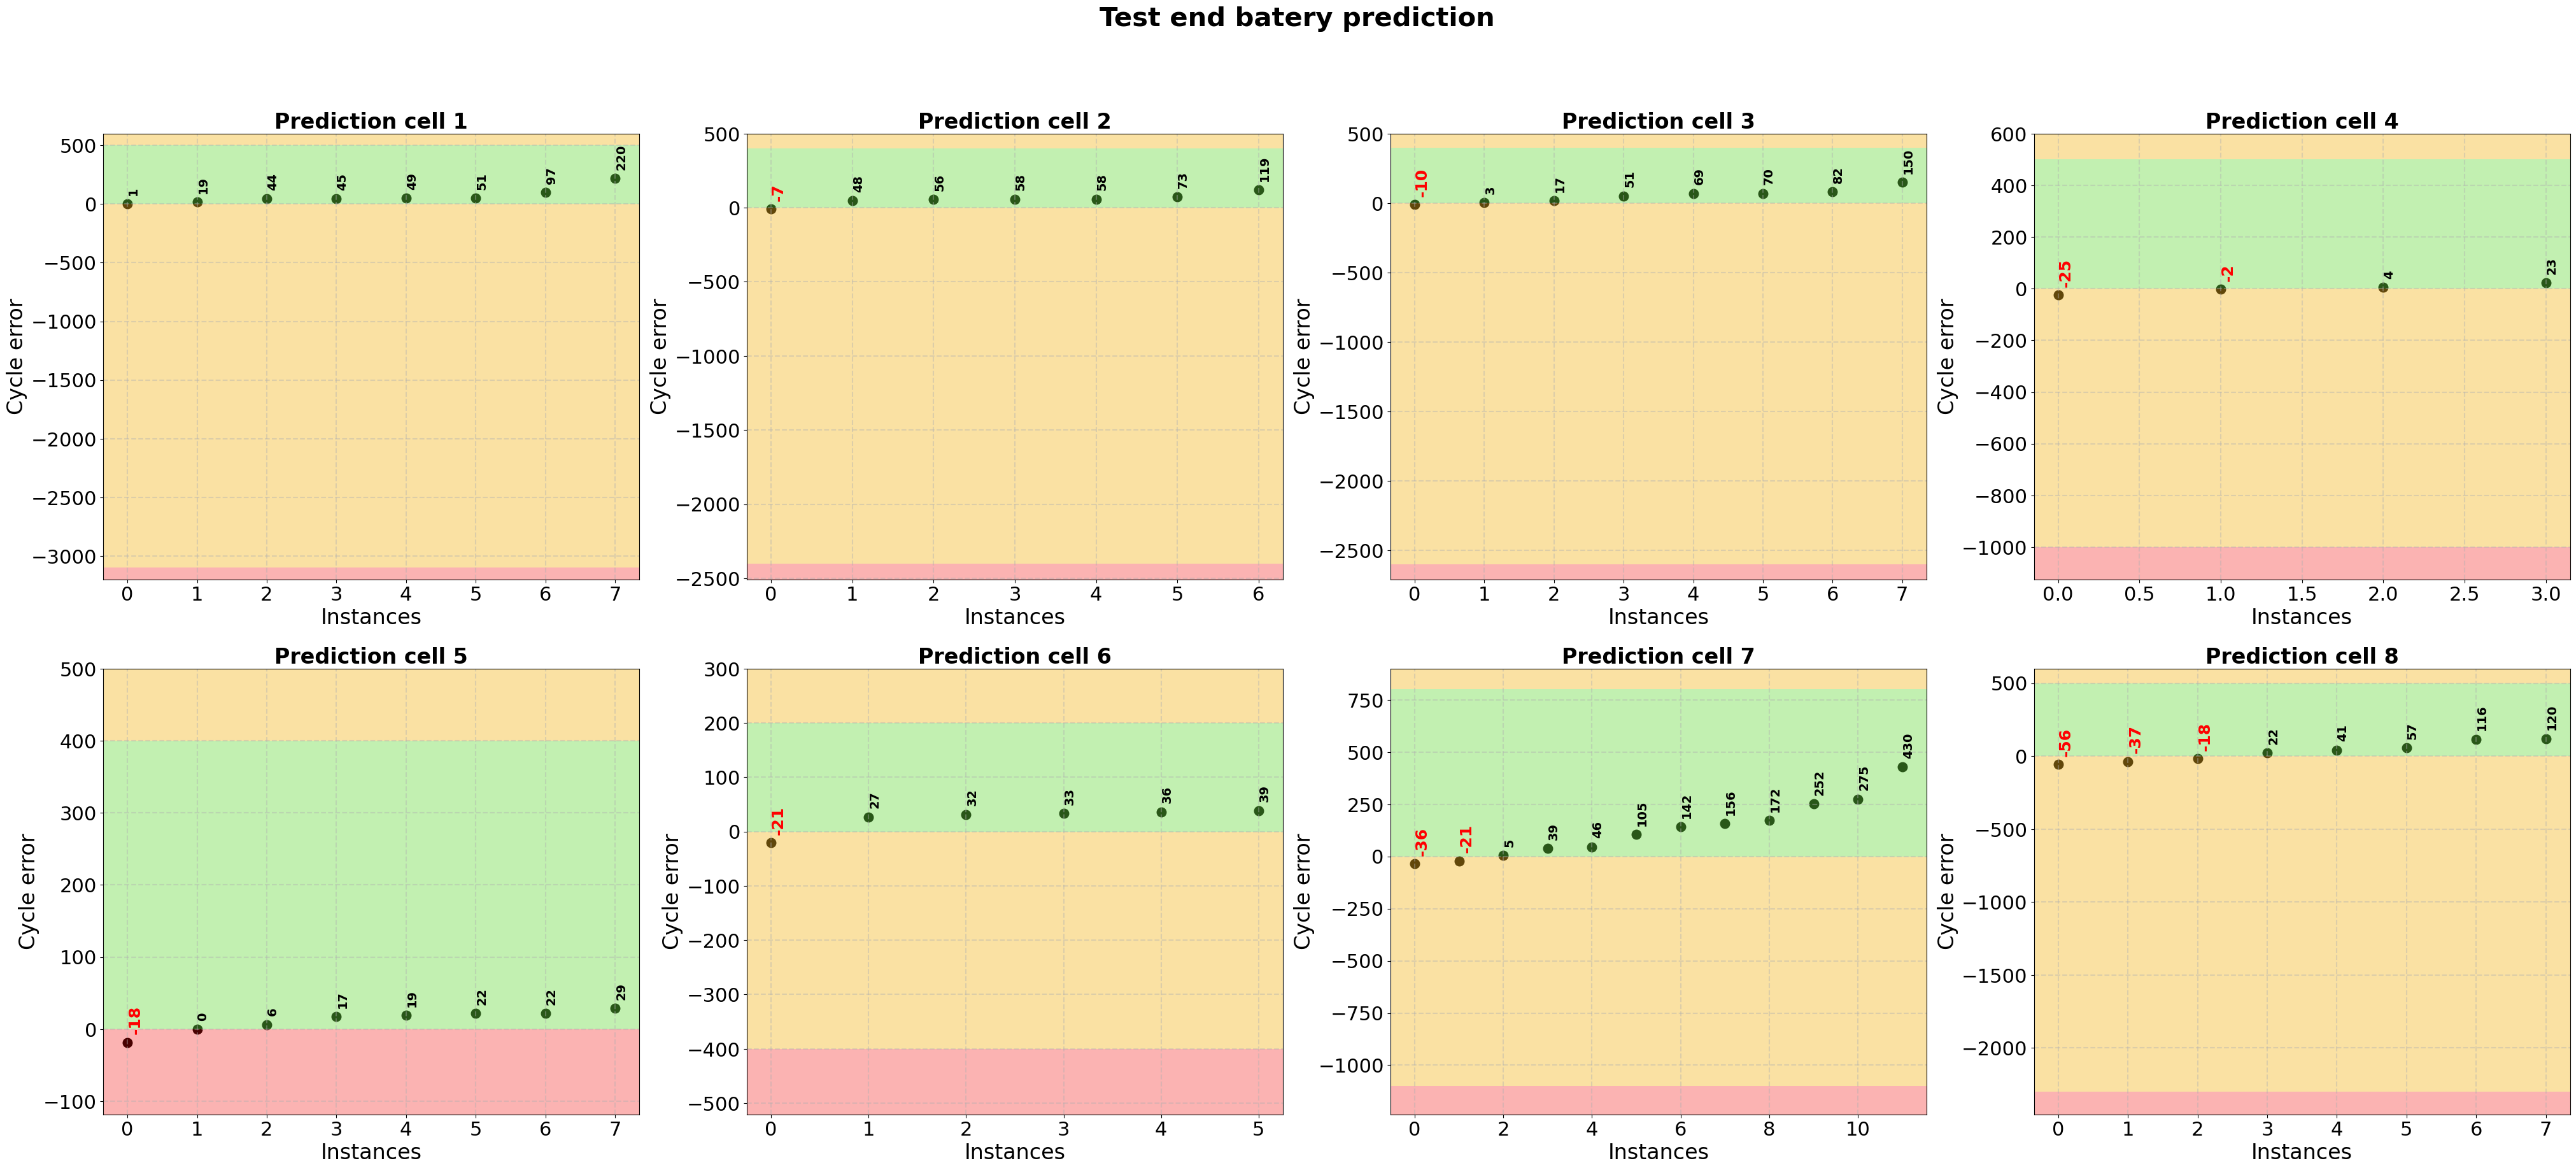

In [13]:
scatter_plot_prediction(ypred, y_test, y_test_mod)
plt.suptitle('Test end batery prediction', fontsize=30, fontweight='bold');

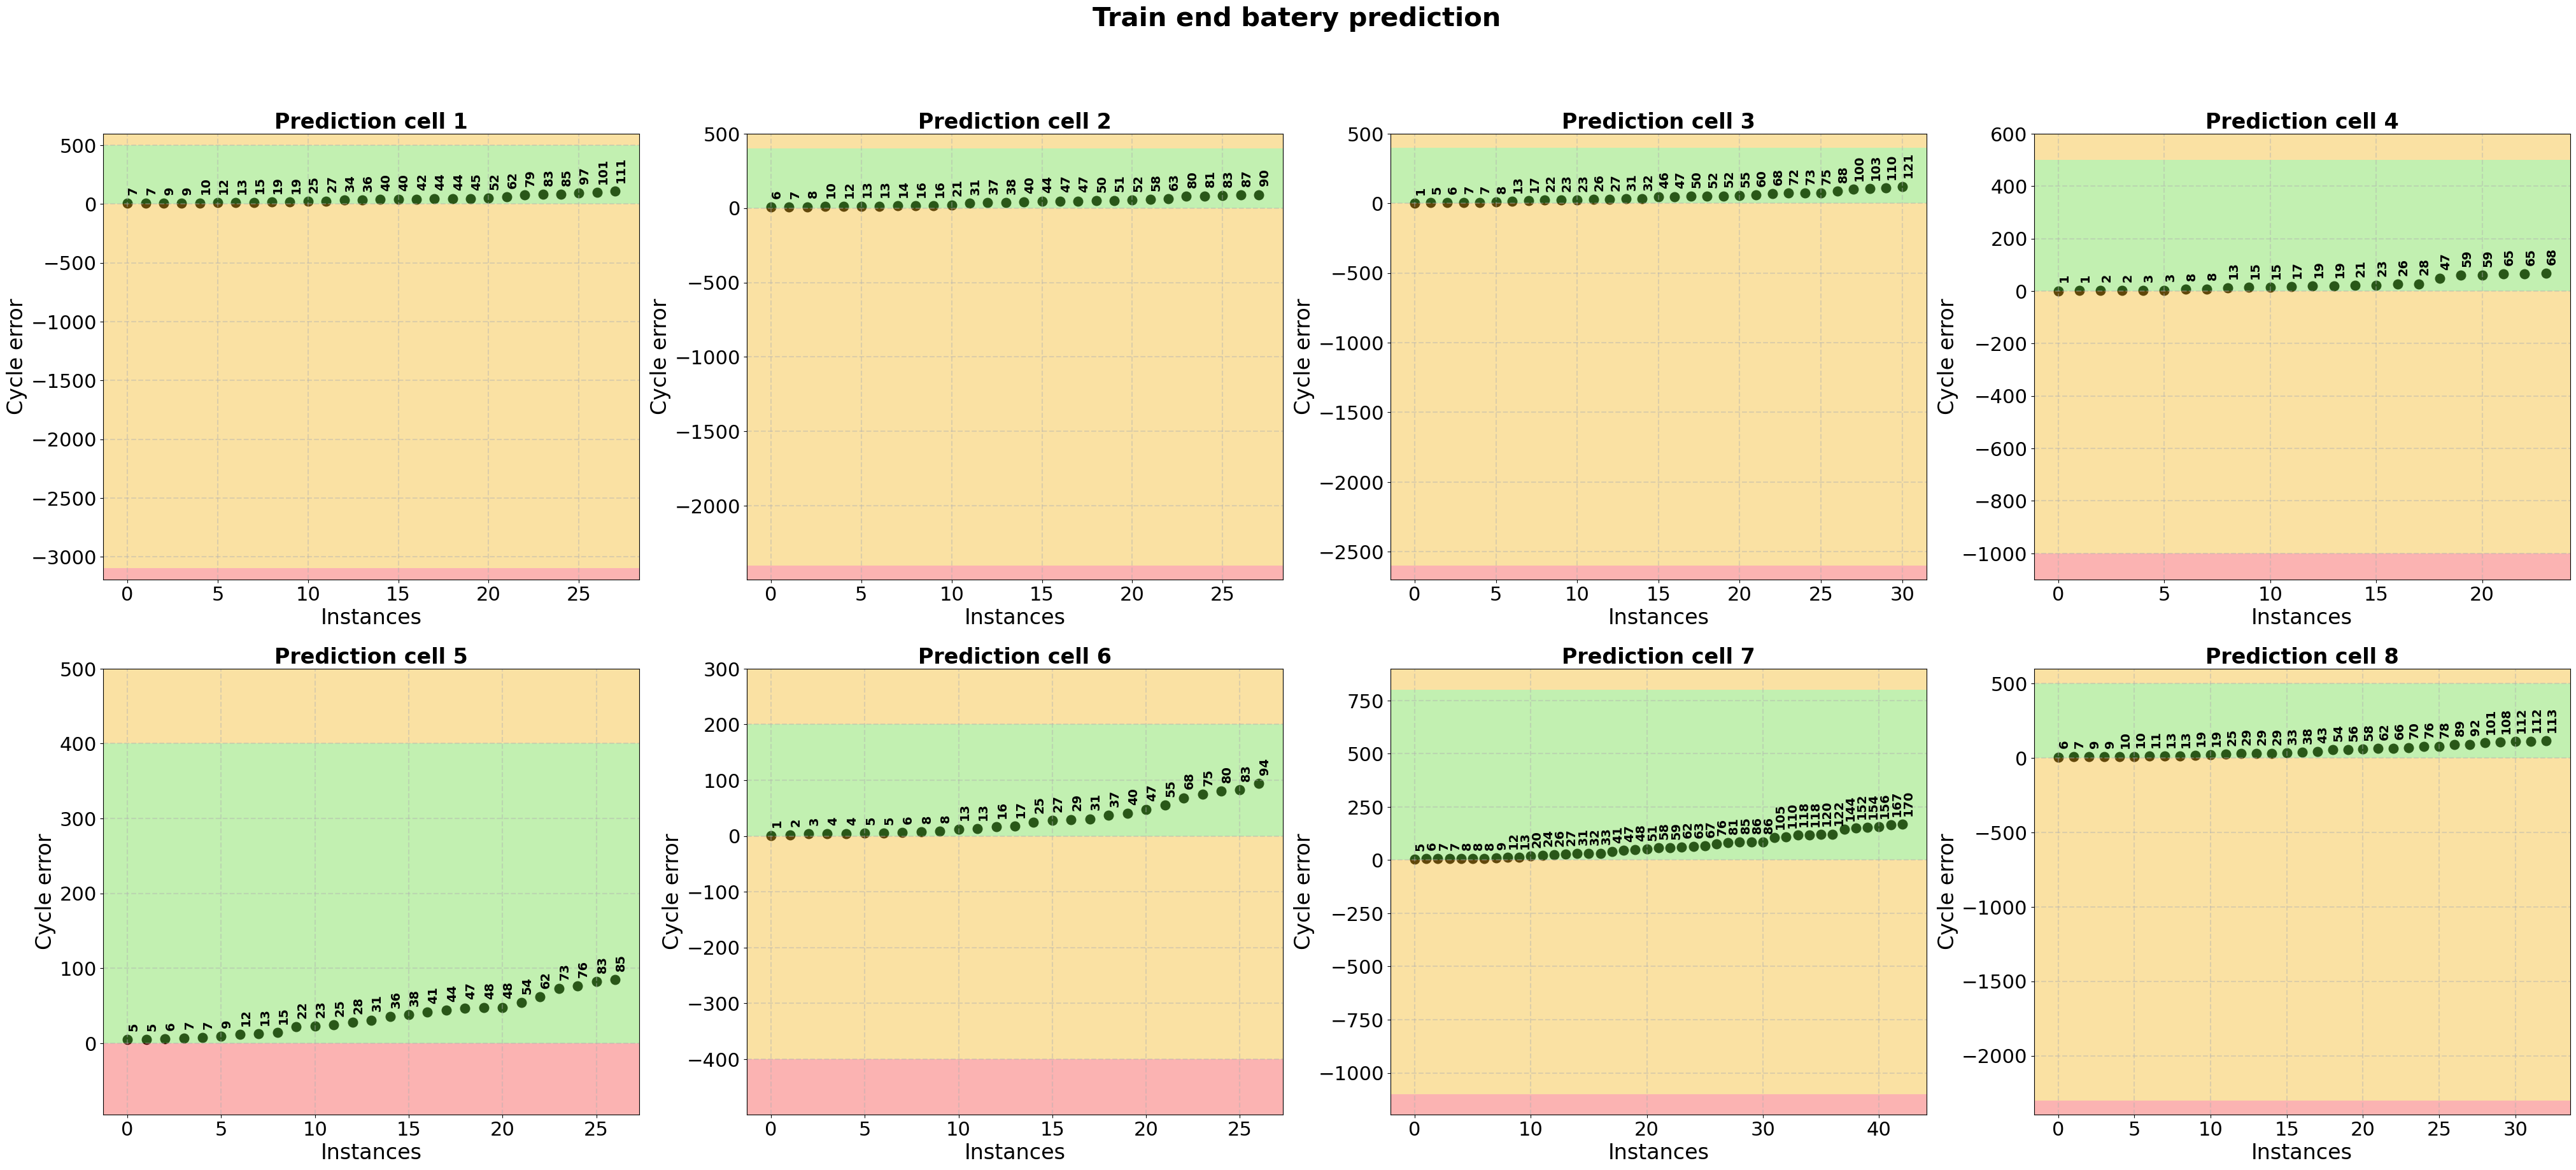

In [14]:
scatter_plot_prediction(ypred_train[:241], y_train, y_train_mod)
plt.suptitle('Train end batery prediction', fontsize=30, fontweight='bold');

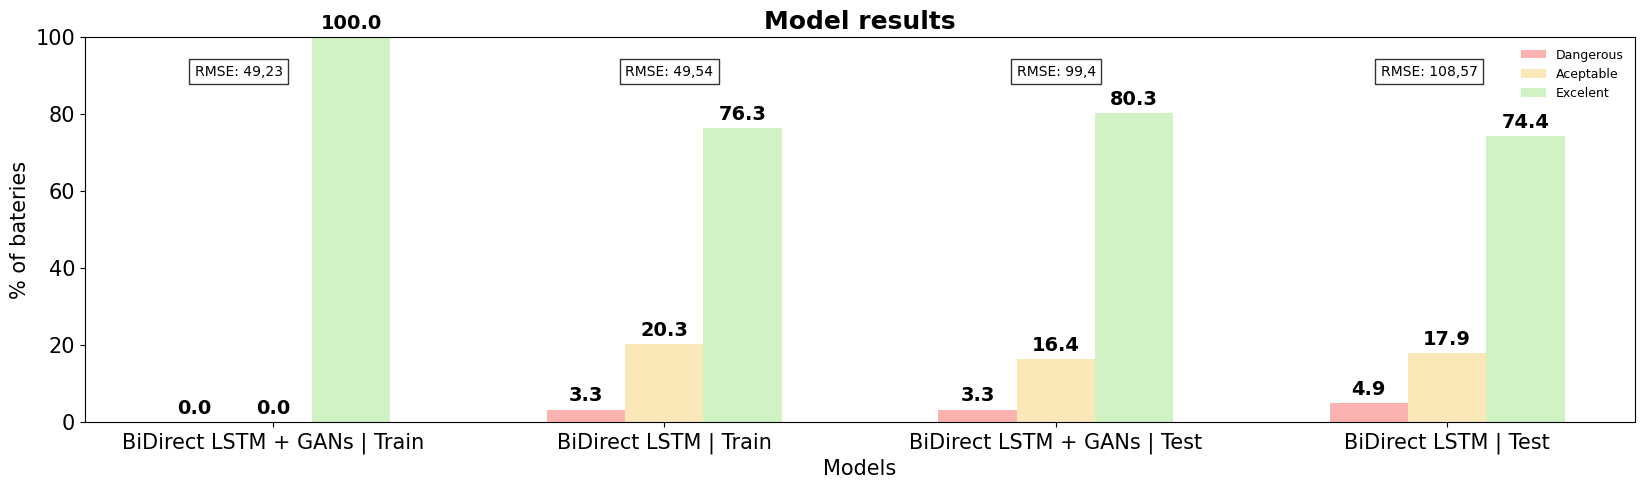

In [44]:
bar_plot_comparison(['BiDirect LSTM + GANs | Train', 'BiDirect LSTM | Train', 'BiDirect LSTM + GANs | Test', 'BiDirect LSTM | Test'], \
                    [red_list_1_train, 3.3, red_list_1_test, 4.9], \
                    [yellow_list_1_train, 20.3, yellow_list_1_test, 17.9], \
                    [green_list_1_train, 76.3, green_list_1_test, 74.4])
plt.legend(loc='upper right', fontsize=9, frameon=False);
plt.text(-0.2, 90, 'RMSE: 49,23', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'));
plt.text(0.9, 90, 'RMSE: 49,54', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'));
plt.text(1.9, 90, 'RMSE: 99,4', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'));
plt.text(2.83, 90, 'RMSE: 108,57', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'));